# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


# please run this notebook in ADS kernel in ADRF

Populating the interactive namespace from numpy and matplotlib


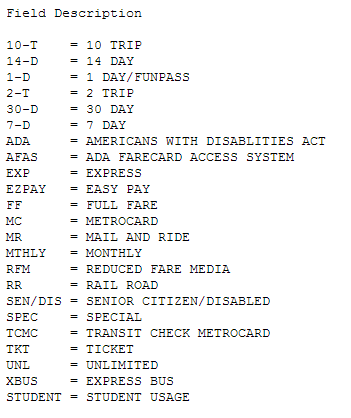

In [1]:


from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# from sklearn import cross_validation, metrics
from sklearn import metrics


from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline
from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [2]:
mta = np.load("MTA_Fare.npy")

In [3]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [4]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [5]:
# mta_nonan = mta
mta = mta[:].astype(float)
# mta_nonan[mta_nonan == -1] = 0
mta[mta == -1] = np.nan

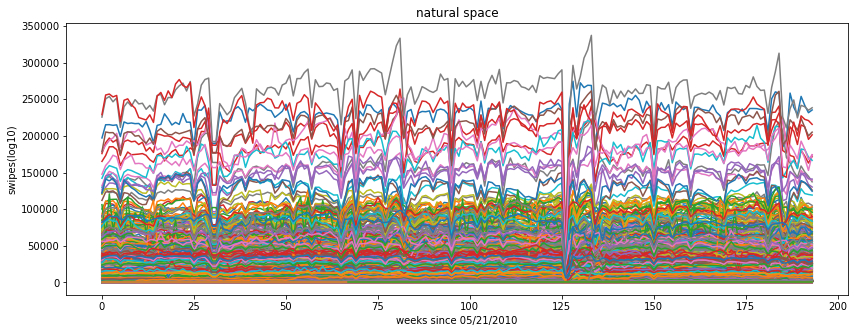

In [6]:
plt.figure(figsize(14,5))
plt.ylabel('swipes(log10)')
plt.xlabel('weeks since 05/21/2010')
plt.title('natural space')
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        plt.plot(mta[i][j])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


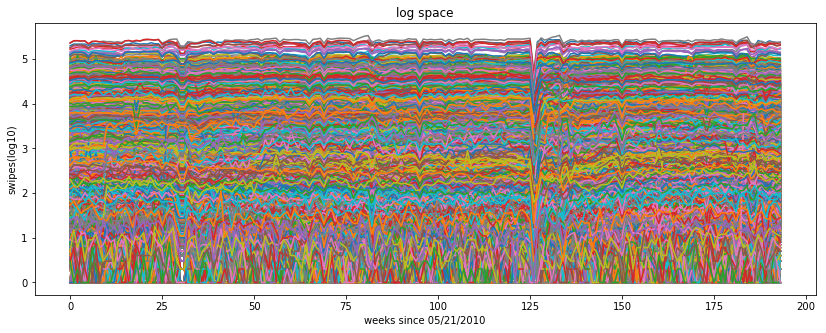

In [7]:

plt.figure(figsize(14,5))
plt.ylabel('swipes(log10)')
plt.xlabel('weeks since 05/21/2010')
plt.title('log space')
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        plt.plot(np.log10(mta[i][j]))

#### Figure 2: time series for all ride types and all stations in semi-log space


# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



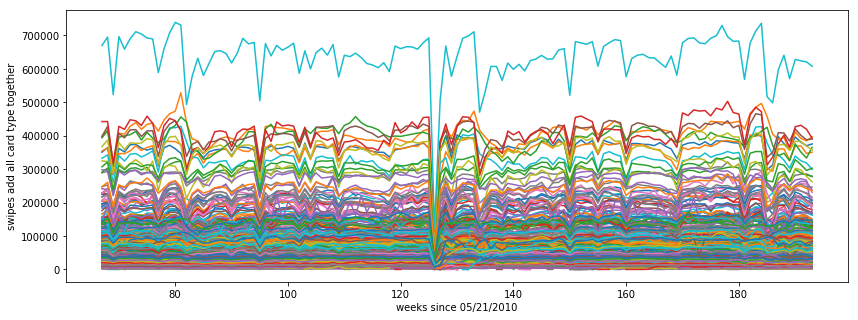

In [8]:

all_card_type = np.zeros((600,194))
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        all_card_type[i] += mta[i][j]
plt.figure(figsize(14,5))
plt.ylabel('swipes add all card type together')
plt.xlabel('weeks since 05/21/2010')
for i in range(mta.shape[0]):
    plt.plot(all_card_type[i])

#### Figure 3: time series for all stations's swipe amount (added different card types together). From this plot, we can tell that the amount of swipe in different stations had the minium value in the same week.

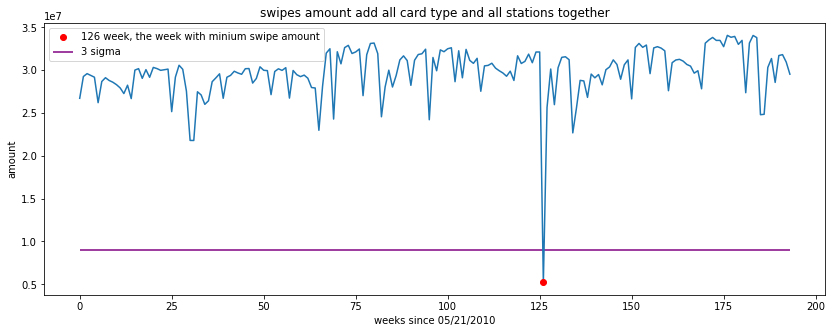

In [9]:
# add up all stations' and all different card types' swipe together to find the week which had the minium swipe in general
each_card = np.nansum(mta, axis=0)
each_station = np.nansum(mta, axis=1)
time_only = (np.nansum(each_card, axis=0)).T
plt.figure(figsize(14,5))
plt.title('swipes amount add all card type and all stations together')
plt.ylabel('amount')
plt.xlabel('weeks since 05/21/2010')
plt.plot(time_only)
plt.plot(time_only.argmin(), time_only[time_only.argmin()], 'ro', label='%s week, the week with minium swipe amount'%time_only.argmin())
plt.hlines(3*(np.nanstd(time_only)),xmin=0, xmax=193, label='3 sigma',color='purple')
plt.legend()

#### Figure 4: time series for all stations's swipe amount (added different card types together). From this plot, we can tell that the amount of swipe in different stations had the minium value in the same week.

In [10]:
date = pd.date_range('05/19/2010', '02/19/2014', freq = 'W')
date[126]

Timestamp('2012-10-21 00:00:00', freq='W-SUN')

### According to WikiPedia, Hurricane Sandy formed Oct. 22, 2012, dissipated Nov. 2, 2012. That was the reason why that week had the minium swipe amount.

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


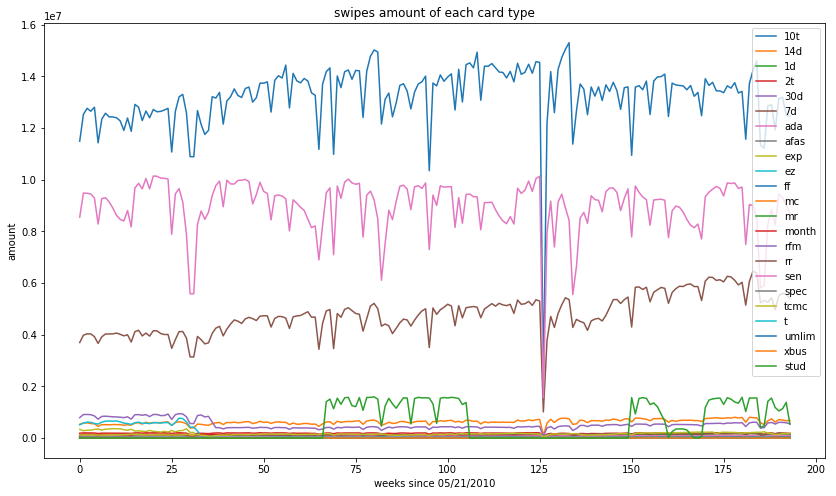

In [11]:
# calculate the sum the each card type
plt.figure(figsize(14,8))
plt.title('swipes amount of each card type')
plt.ylabel('amount')
plt.xlabel('weeks since 05/21/2010')
plt.legend()
for i in range(each_card.shape[0]):
    plt.plot(each_card[i], label=ridetype[i])
plt.legend()

#### Figure 4: time series for the sum of different card in each station. From this plot, we can tell that the amount of swipe in different stations had the minium value in the same week.

In [12]:
df_card = pd.DataFrame(each_card)
df_card_rolling_mean = df_card.rolling(10,axis=1, min_periods=1).mean()
df_card_rolling_std = df_card.rolling(10,axis=1, min_periods=1).std()

In [13]:
df_card_rolling_mean.head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,11494615.0,12010737.0,1.226270e+07,12360444.00,12450294.0,1.228021e+07,1.228973e+07,1.232561e+07,1.233800e+07,12347326.1,...,13525673.9,13322951.1,13081533.1,13013208.5,12927570.5,12784792.4,12756491.7,12918506.7,12794971.1,12616472.2
1,530524.0,557028.5,5.667503e+05,565713.25,562342.2,5.445670e+05,5.407984e+05,5.373751e+05,5.345770e+05,533376.2,...,768354.5,751696.1,725075.4,714403.5,708456.7,691998.4,683817.6,692278.2,678913.9,667821.7
2,47801.0,49643.5,5.030767e+04,50746.50,50827.8,5.016517e+04,4.999343e+04,4.994788e+04,4.984589e+04,49898.9,...,62704.1,61505.8,59657.5,58970.1,58361.1,57259.0,56608.7,57244.2,56377.4,55454.9
3,186551.0,192890.0,1.951493e+05,195459.25,195344.0,1.920613e+05,1.915479e+05,1.911156e+05,1.906386e+05,190627.5,...,197898.7,194518.2,188812.3,186284.8,185022.0,181911.2,180559.5,181912.8,179860.5,178008.6
4,46808.0,55580.5,5.605167e+04,51396.00,48158.8,4.794050e+04,4.969543e+04,4.941338e+04,4.748789e+04,47956.2,...,55352.8,52133.2,49744.9,51826.9,51765.5,49784.2,49070.7,52127.3,51639.6,49576.5


In [14]:
std = np.zeros(23)
for i in range(each_card.shape[0]):
    std[i] = np.nanstd(each_card[i])

relative smooth change stdev: 23741.9078393    fractional change over time: 0.645284811669
relative not smooth change stdev: 171277.595789    fractional change over time: 0.693938692081


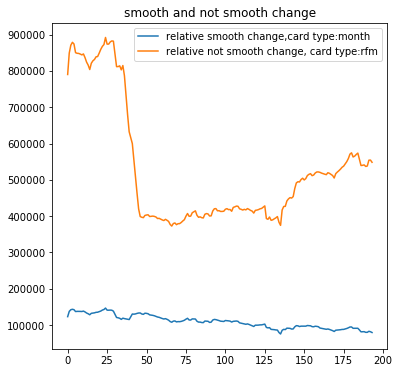

In [15]:
fc1 = abs(df_card_rolling_mean.iloc[13][193] / df_card_rolling_mean.iloc[13][0])
fc2 = abs(df_card_rolling_mean.iloc[14][193] / df_card_rolling_mean.iloc[14][0])

print('relative smooth change','stdev:', std[13], '   fractional change over time:', fc1)
print('relative not smooth change','stdev:', std[14], '   fractional change over time:', fc2)

plt,figure(figsize=(6,6))
plt.title('smooth and not smooth change')
plt.plot(df_card_rolling_mean.iloc[13], label='relative smooth change,card type:'+ridetype[13])
plt.plot(df_card_rolling_mean.iloc[14], label='relative not smooth change, card type:'+ridetype[14])
plt.legend()

#### Figure 5: time series for the rolling average of two different cards in each station: a relative smooth one and a relative not smooth one. These two cards have a close values of fractional change over time, but the value of stdev are very different.

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [16]:
mta_notype = mta.reshape(13800,194)
df_station = pd.DataFrame(mta_notype)
value = df_station.values
value = value[~np.isnan(value).any(axis=1)]
value.shape

# the time series mean divided by the mean of all time series for that station
mean_station = np.nanmean(each_station, axis=1)
mean_station = np.repeat(mean_station, 23)
df_station['station_mean'] = mean_station
mean = df_station.mean(axis=1, skipna=True)

# the time series standard deviation by the standard deviation of all time series for that station
std_station = np.nanstd(each_station, axis=1)
std_station = np.repeat(std_station, 23)
df_station['station_std'] = std_station
std = df_station.std(axis=1, skipna=True)

# add the std and mean to dataframe after the calculation for both
df_station['mean'] = mean
df_station['std'] = std
df_station['mean_divide'] = df_station['mean'] / df_station['station_mean']
df_station['std_divide'] = df_station['std'] / df_station['station_std']

# df_station['type'] = np.tile(np.arange(23),600)
df_station['type'] = np.tile(ridetype,600)
df_station['station'] = np.repeat((np.arange(600)),23)


df_station = df_station.dropna(axis=0, how='any')
# # calculate the intercept and slope
scaled = preprocessing.StandardScaler().fit_transform(value)
time_series = np.arange(194)
intercept = []
slope = []
for i in range(scaled.shape[0]):
    y = time_series
    x = sm.add_constant(scaled[i])
    mod = sm.OLS(y, x).fit()
    intercept.append(mod.params[0])
    slope.append(mod.params[1])
    
# add the result to DataFrame

df_station['intercept'] = intercept
df_station['slope'] = slope

# del useless column
del df_station['station_mean']
del df_station['mean']
del df_station['station_std']
del df_station['std']

df_station.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,mean_divide,std_divide,type,station,intercept,slope
46,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,2888.0,3591.0,...,3418.0,3746.0,3406.0,3217.0,0.492518,0.516822,10t,2,115.766512,-461.439846
47,110.0,92.0,102.0,79.0,93.0,74.0,72.0,92.0,97.0,95.0,...,191.0,212.0,209.0,211.0,0.024985,0.522880,14d,2,817.076120,3005.337979
48,7.0,6.0,13.0,7.0,5.0,7.0,7.0,6.0,3.0,4.0,...,19.0,26.0,20.0,22.0,0.007592,0.531323,1d,2,-310.077430,-1624.982845
49,41.0,51.0,47.0,37.0,50.0,43.0,44.0,32.0,43.0,57.0,...,31.0,28.0,24.0,22.0,0.009284,0.530349,2t,2,-753.219949,-3410.264934
50,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,5.0,5.0,6.0,0.0,0.005526,0.532503,30d,2,-413.121703,-2026.782663


## Build a model input 4 variables from feature engineering

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.476895541816


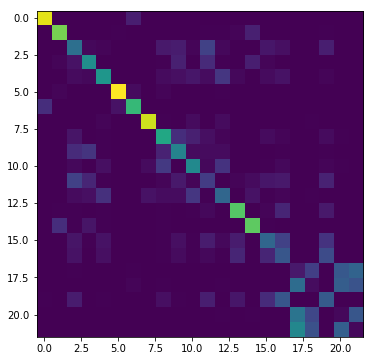

In [17]:
X = df_station[['mean_divide', 'std_divide', 'intercept', 'slope']]
y = df_station[['type']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
rf0 = rfc(n_estimators=100, oob_score=True, random_state=10, max_features=4, n_jobs=4)
rf0.fit(X_train,y_train)
print (rf0.oob_score_)
y_pred = rf0.predict(X_test)

plt.figure(figsize=(6,6))
im = plt.imshow(confusion_matrix(y_test, y_pred), interpolation='none')
plt.show()
# print(rf0.predict(X))
# y_predprob = rf0.predict_proba(X)[:,2]

In [18]:
# as all the card type 'stu' contains nan
ridetype_new = ridetype[:22]
print(classification_report(y_test, y_pred, target_names=ridetype_new))

              precision    recall  f1-score   support

         10t       0.87      0.92      0.90       151
         14d       0.83      0.86      0.84       134
          1d       0.34      0.38      0.36       139
          2t       0.55      0.56      0.56       126
         30d       0.61      0.52      0.56       146
          7d       0.95      0.94      0.94       154
         ada       0.84      0.79      0.81       123
        afas       0.92      0.92      0.92       146
         exp       0.54      0.59      0.56       147
          ez       0.46      0.49      0.47       134
          ff       0.53      0.50      0.52       137
          mc       0.22      0.21      0.21       123
          mr       0.42      0.37      0.39       130
       month       0.72      0.75      0.74       142
         rfm       0.75      0.78      0.76       140
          rr       0.42      0.33      0.37       146
         sen       0.26      0.31      0.28       125
        spec       0.05    

#### Figure 6: This plot shows the predict result of random forest. The more yellow the grid is, means the type in x axis in more predict as the type in y axis; and the more blue the grid is, means the type in x axis in less predict as the type in y axis. We can tell that from type 0 to type 15, the correctly predicted value is obviously more than incorrectly predicted value. But from type 15 to type 23, the predict ability of this model decrease significantly.

## Build a model that uses as input features each time stamp (194 features) :


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.685323787829


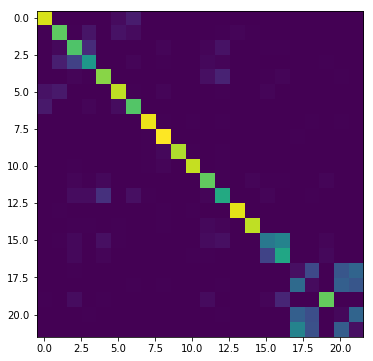

In [19]:
X = df_station.drop(columns=['mean_divide', 'std_divide', 'intercept', 'slope', 'type'])
y = df_station[['type']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
rf1 = rfc(n_estimators=100, oob_score=True, random_state=10, max_features='auto', n_jobs=4)
rf1.fit(X_train,y_train)
print (rf1.oob_score_)
y_pred = rf1.predict(X_test)
plt.figure(figsize=(6,6))
im = plt.imshow(confusion_matrix(y_test, y_pred), interpolation='none')
plt.show()

#### Figure 7: This plot shows the predict result of random forest. The more yellow the grid is, means the type in x axis in more predict as the type in y axis; and the more blue the grid is, means the type in x axis in less predict as the type in y axis. We can tell that from type 0 to type 15, the correctly predicted value is obviously more than incorrectly predicted value. But from type 15 to type 23, the predict ability of this model decrease significantly. More over, the out-of-bag sample score in the model is higher than the first one. As a result, there is a clearer line in this plot, but this model failed to predict type 15 to type 23 as well.

In [20]:
print(classification_report(y_test, y_pred, target_names=ridetype_new))

              precision    recall  f1-score   support

         10t       0.88      0.90      0.89       151
         14d       0.80      0.81      0.81       134
          1d       0.67      0.76      0.71       139
          2t       0.68      0.61      0.64       126
         30d       0.79      0.82      0.80       146
          7d       0.88      0.85      0.86       154
         ada       0.81      0.86      0.83       123
        afas       0.97      0.97      0.97       146
         exp       0.91      0.99      0.95       147
          ez       1.00      0.96      0.98       134
          ff       0.97      0.96      0.97       137
          mc       0.81      0.89      0.85       123
          mr       0.69      0.68      0.68       130
       month       0.99      0.98      0.98       142
         rfm       0.98      0.94      0.96       140
          rr       0.60      0.40      0.48       146
         sen       0.51      0.69      0.58       125
        spec       0.04    

# 4. Fourier transform
from the numpy package you will nees only the 
np.fft.rfft() to take the fourier transform

and

np.fft.rfftfreq() to create a meaningful x axis 

In [30]:
mta = np.load("MTA_Fare.npy")
mta = mta[:].astype(float)
# mta_nonan[mta_nonan == -1] = 0
mta[mta == -1] = np.nan
mta = mta[~np.isnan(mta).any(axis=2)]

In [31]:
mta.shape

(9174, 194)

In [33]:
np.fft.rfft(mta, axis=1)

array([[  6.88490000e+05 +0.00000000e+00j,
         -9.24014790e+03 -4.79450700e+03j,
         -5.76566708e+03 +7.36989386e+03j, ...,
          5.03716654e+03 -3.51491216e+03j,
          2.17216302e+03 +8.52047263e+03j,
          1.00400000e+03 +0.00000000e+00j],
       [  2.80500000e+04 +0.00000000e+00j,
          6.47728618e+02 +4.32827643e+03j,
         -5.25392515e+02 +2.27365029e+03j, ...,
          2.58643617e+02 -3.19458835e+02j,
          1.17053649e+02 +4.10223911e+02j,
         -2.20000000e+01 +0.00000000e+00j],
       [  3.48000000e+03 +0.00000000e+00j,
         -1.23230206e+02 +3.56637065e+02j,
         -1.31163081e+02 +6.30760478e+02j, ...,
          2.34438395e+01 +1.93691018e+01j,
          4.33996140e+01 +7.14614342e+00j,
          2.40000000e+01 +0.00000000e+00j],
       ..., 
       [  0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j, ...,
          0.00000000e+00 +0.00000000e+00j,
          0.000000